In [ ]:
import numpy as np
from keras import layers, backend
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras import utils as np_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
from keras.initializers import glorot_uniform 
import scipy.misc
from matplotlib.pyplot import imshow
from keras.initializers import glorot_uniform
from tensorflow import keras
from keras.applications import imagenet_utils
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import warnings
import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
import tensorflow as tf
tf.__version__

!sudo pip3 install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tensorflow.keras.layers import Layer, InputSpec

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# pixels range from 0 to 255 so dividing by 255 so value lie between 0 and 1 and ML works best with numbers between 0 and 1.
# We split dataset into training and validation category. Model learns from Train data and Model accuracy is checked with Validation data as this is the data model has not train on. (unknown real world image)

normal = glob.glob('../content/drive/MyDrive/cleandata/train/NORMAL/*.*')
pneumonia = glob.glob('../content/drive/MyDrive/cleandata/train/PNEUMONIA/*.*')
tuber = glob.glob('../content/drive/MyDrive/cleandata/train/TURBERCULOSIS/*.*')

normal_test = glob.glob('../content/drive/MyDrive/cleandata/test/NORMAL/*.*')
pneumonia_test = glob.glob('../content/drive/MyDrive/cleandata/test/PNEUMONIA/*.*')
tuber_test = glob.glob('../content/drive/MyDrive/cleandata/test/TURBERCULOSIS/*.*')
 
normal.extend(normal_test)
pneumonia.extend(pneumonia_test)
tuber.extend(tuber_test)


data = []
labels = []


for i in normal:   
    image=tf.keras.preprocessing.image.load_img(i, 
    target_size= (224,224,3))
    image=np.array(image)
    data.append(image)
    labels.append(0)
for i in pneumonia[:566]:   
    image=tf.keras.preprocessing.image.load_img(i,  
    target_size= (224,224,3))
    image=np.array(image)
    data.append(image)
    labels.append(1)
for i in tuber[:566]:   
    image=tf.keras.preprocessing.image.load_img(i, 
    target_size= (224,224,3))
    image=np.array(image)
    data.append(image)
    labels.append(2)

data = np.array(data)
labels = np.array(labels)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.20,random_state=42,stratify=labels)


In [ ]:
def identity_block(X, f, filters):
  #retrive filters
  F1, F2, F3 = filters

  X_shortcut = X


#first layer
  X= Conv2D(filters = F1, kernel_size=(1,1), strides = (1,1), padding = 'same')(X)
  X= BatchNormalization(axis=3)(X)
  X= Activation('relu')(X)

  #second layer
  X= Conv2D(filters = F2, kernel_size=(f,f), strides = (1,1), padding = 'same')(X)
  X= BatchNormalization(axis=3)(X)
  X= Activation('relu')(X)

  #third layer
  X= Conv2D(filters = F3, kernel_size=(1,1),strides = (1,1), padding = 'same')(X)
  X= BatchNormalization(axis=3)(X)


  #final step: adding shoetcut value to F(x), and pass it through Relu activation
  X= Add()([X, X_shortcut])
  X= Activation('relu')(X)

  return X
           
  

In [ ]:
def convolution_block(X, f, filters, s=2):
  #retrive filters
  F1, F2, F3 = filters
#saving the input value
  X_shortcut = X

#first layer
  X= Conv2D(F1, (1,1), strides = (s,s))(X) #1,1 is a filter size
  X= BatchNormalization(axis=3)(X)
  X= Activation('relu')(X)

#second layer (f,f)=3*3 filter by default
  X= Conv2D(filters = F2, kernel_size=(f,f), strides = (1,1), padding = 'same')(X)
  X= BatchNormalization(axis=3)(X)
  X= Activation('relu')(X)

#third layer
  X= Conv2D(filters = F3, kernel_size=(1,1),strides = (1,1), padding = 'same')(X)
  X= BatchNormalization(axis=3)(X)

#shortcutpath
  X_shortcut= Conv2D(filters = F3, kernel_size=(1,1),strides = (s,s), padding = 'same')(X_shortcut)
  X_shortcut= BatchNormalization(axis=3)(X_shortcut)


  #final step: adding shoetcut value to F(x), and pass it through Relu activation
  X= Add()([X, X_shortcut])
  X= Activation('relu')(X)


  return X
  

In [ ]:
#from keras.engine.input_layer import InputLayer
def ResNet50(input_shape=(224,224,3), classes=3):

  
  #defining the input with shape input_shape
  X_input = Input(input_shape)
  #keras.layers.Input(input_shape=(224, 224, 3))
  #zero padding
  x = ZeroPadding2D((3,3))( X_input) #3,3 padding

  #stage1
  x= Conv2D(64,(7,7), strides = (2,2))(x) #1,1 is a filter size
  x= BatchNormalization(axis=3)(x)
  x= Activation('relu')(x)
  x= MaxPooling2D((3,3), strides=(2,2))(x)


#second layer
  x = convolution_block(x, f=3, filters=[64,64,256], s=1)
  x = identity_block(x, 3, [64,64,256])
  x = identity_block(x, 3, [64,64,256])

#third stage
  x = convolution_block(x, f=3, filters=[128,128,512], s=2)
  x = identity_block(x, 3, [128,128,512])
  x = identity_block(x, 3, [128,128,512])  
  x = identity_block(x, 3, [128,128,512])

#fourth stage
  x = convolution_block(x, f=3, filters=[256,256,1024], s=2)
  x = identity_block(x, 3, [256,256,1024])
  x = identity_block(x, 3, [256,256,1024])  
  x = identity_block(x, 3, [256,256,1024])
  x = identity_block(x, 3, [256,256,1024])
  x = identity_block(x, 3, [256,256,1024])

#fifth stage
  x = convolution_block(x, f=3, filters=[512,512,2048], s=2)
  x = identity_block(x, 3, [512,512,2048])
  x = identity_block(x, 3, [512,512,2048])

#average pool
  x = AveragePooling2D((2,2),name="avg_pool")(x)

#output layer
  x = Flatten()(x)
  x = Dense(classes, activation='softmax',name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=42))(x)

#creating a model
  model = Model(inputs = X_input, outputs=x, name='ResNet50')

  return model






In [ ]:
model = ResNet50(input_shape=(224,224,3), classes=3)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                           

In [ ]:
y_train_res = tf.keras.utils.to_categorical(y_train,3)
y_test_res = tf.keras.utils.to_categorical(y_test,3)

In [ ]:
y_train_res

array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
X_train = tf.expand_dims(X_train,axis=-1)

In [ ]:
y_train_res.shape

(2165, 3)

In [ ]:
X_test = tf.expand_dims(X_test,axis=-1)

In [ ]:
X_test.shape

TensorShape([542, 224, 224, 3, 1])

In [ ]:
checkpointer = EarlyStopping(monitor = 'val_accuracy', verbose = 1, restore_best_weights=True,mode="max",patience = 8)
# checkpointer to monitor accuracy and preventing overfit
# if validation accuracy do not imporve for 15 turns the training will stop.

In [ ]:
history = model.fit(
            X_train,
            y_train_res,
            epochs=20,
            verbose=1,
            validation_split= 0.2,
            callbacks = [checkpointer])

Epoch 1/20
55/55 [==============================] - 157s 3s/step - loss: 2.1745 - accuracy: 0.7413 - val_loss: 359.4837 - val_accuracy: 0.2055
Epoch 2/20
55/55 [==============================] - 148s 3s/step - loss: 0.5854 - accuracy: 0.8643 - val_loss: 0.8967 - val_accuracy: 0.7021
Epoch 3/20
55/55 [==============================] - 153s 3s/step - loss: 0.7158 - accuracy: 0.8707 - val_loss: 20.9094 - val_accuracy: 0.1640
Epoch 4/20
55/55 [==============================] - 147s 3s/step - loss: 1.3834 - accuracy: 0.8164 - val_loss: 58.0535 - val_accuracy: 0.2055
Epoch 5/20
55/55 [==============================] - 146s 3s/step - loss: 0.3435 - accuracy: 0.9053 - val_loss: 51.4909 - val_accuracy: 0.6005
Epoch 6/20
55/55 [==============================] - 147s 3s/step - loss: 0.1908 - accuracy: 0.9342 - val_loss: 175.7510 - val_accuracy: 0.7136
Epoch 7/20
55/55 [==============================] - 146s 3s/step - loss: 0.1273 - accuracy: 0.9561 - val_loss: 1.9187 - val_accuracy: 0.8453
Epoch 

In [ ]:
print(f"Final Train accuracy = {model.evaluate(X_train,y_train_res)[1]*100}%")
print(f"Validation accuracy = {model.evaluate(X_test,y_test_res)[1]*100}%")

68/68 [==============================] - 34s 493ms/step - loss: 0.0893 - accuracy: 0.9723
Final Train accuracy = 97.22864031791687%
17/17 [==============================] - 8s 489ms/step - loss: 0.1157 - accuracy: 0.9520
Validation accuracy = 95.20295262336731%


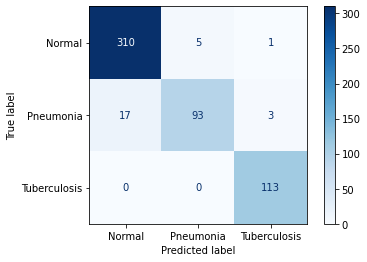

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
prediction = model.predict(X_test)
cm = confusion_matrix(y_test_res.argmax(axis=1), prediction.argmax(axis=1))
labels = ["Normal","Pneumonia","Tuberculosis"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
import pickle
with open('modelresneton20epochs8020_pickle','wb') as f:
  pickle.dump(model,f)

INFO:tensorflow:Assets written to: ram://6ee8c990-e55c-4f0d-b438-0e5b46baaf6c/assets


In [ ]:
import tensorflow as tf
from keras.models import load_model
model.save('newstartresnetachhahai.h5')

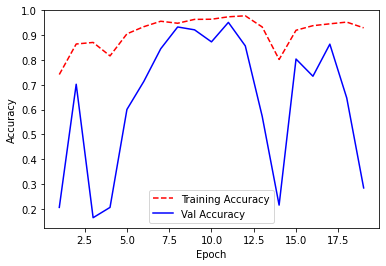

In [ ]:
training_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)

# Visualize loss history

plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, val_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(top = 1)
plt.show()